# 0. 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import xgboost
from xgboost import XGBClassifier

import time

In [3]:
print("library version check")
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", mpl.__version__)
print("sklearn: ", sklearn.__version__)
print("xgboost", xgboost.__version__)

library version check
numpy:  1.23.5
pandas:  1.5.1
seaborn:  0.12.1
matplotlib:  3.6.2
sklearn:  1.1.3
xgboost 2.0.3


In [4]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

* no(재직): 0
* yes(퇴직): 1

In [5]:
train = pd.read_csv("../data/hr_train_scaling.csv",
                    index_col = 0)

test = pd.read_csv("../data/hr_test_scaling.csv",
                    index_col = 0)

In [6]:
train.head()

,job_satisfaction,working_hours,num_companies_worked,age,years_at_company,salary_increasing_rate,department_hr,department_rnd,department_sales,marital_status_etc,marital_status_married,marital_status_single,attrition
1274,1.000000,0.356223,0.111111,0.309524,0.325,0.558212,0.0,0.0,1.0,0.0,1.0,0.0,0
1080,0.333333,0.858369,0.888889,0.666667,0.575,0.492676,0.0,0.0,1.0,0.0,1.0,0.0,0
1387,0.000000,0.484979,0.000000,0.261905,0.150,0.468004,0.0,1.0,0.0,0.0,1.0,0.0,0
971,0.333333,0.227468,0.333333,0.785714,0.725,0.653046,0.0,1.0,0.0,0.0,0.0,1.0,0
62,0.666667,0.613734,0.555556,0.761905,0.725,0.494218,0.0,1.0,0.0,1.0,0.0,0.0,0


In [7]:
x_train = train[train.columns[:-1]].values
y_train = train["attrition"].values

x_test = test[test.columns[:-1]].values
y_test = test["attrition"].values

In [8]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (1094, 12)
y_train:  (1094,)
x_test:  (365, 12)
y_test:  (365,)


# k-NN

In [9]:
## HR 데이터에 k-NN 모델을 적용하여 attrition을 분류하는 모델을 만드시오.
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(x_train, y_train)
pred_knn = knn.predict(x_test)
print('The accuracy of the KNN is', metrics.accuracy_score(pred_knn, y_test))

The accuracy of the KNN is 0.8328767123287671


# DT

In [10]:
## HR 데이터에 DT 모델을 적용하여 attrition을 분류하는 모델을 만드시오.
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(x_train, y_train)
pred_tree = tree.predict(x_test)
print('The accuracy of the DT is', metrics.accuracy_score(pred_tree, y_test))

The accuracy of the DT is 0.7671232876712328


# RFC

In [11]:
# gridsearch
def grid_search(params, model, core):
    model_grid = GridSearchCV(model, 
                              params, 
                              cv=5, 
                              return_train_score=True,
                              n_jobs = core
                             )
    model_grid.fit(x_train, y_train)
    
    print('최상의 매개변수: ', model_grid.best_params_)
    print('훈련 데이터의 최고 정확도: ', model_grid.best_score_)
    
    model_best = model_grid.best_estimator_
    pred_best = model_best.predict(x_test)
    print('테스트 데이터의 최고 정확도: ', metrics.accuracy_score(pred_best, y_test))

In [12]:
## HR 데이터에 RFC 모델을 적용하여 attrition을 분류하는 모델을 만드시오.
rfc = RandomForestClassifier(oob_score=True, random_state=209) 
rfc.fit(x_train, y_train)
pred_rfc = rfc.predict(x_test)
print('The accuracy of the RFC is', metrics.accuracy_score(pred_rfc, y_test))

The accuracy of the RFC is 0.8246575342465754


In [13]:
## tree의 개수에 따른 OOB score를 계산하고, OOB score에 대한 그래프를 그리시오.
oob_score = []
estimators = [i for i in range(100, 400, 50)]

for i in estimators :
    rfc = RandomForestClassifier(n_estimators = i, 
                                  oob_score = True,
                                  random_state = 209,
                                  #n_jobs = -1
                                  )
    rfc.fit(x_train, y_train)
    oob_score.append(rfc.oob_score_)

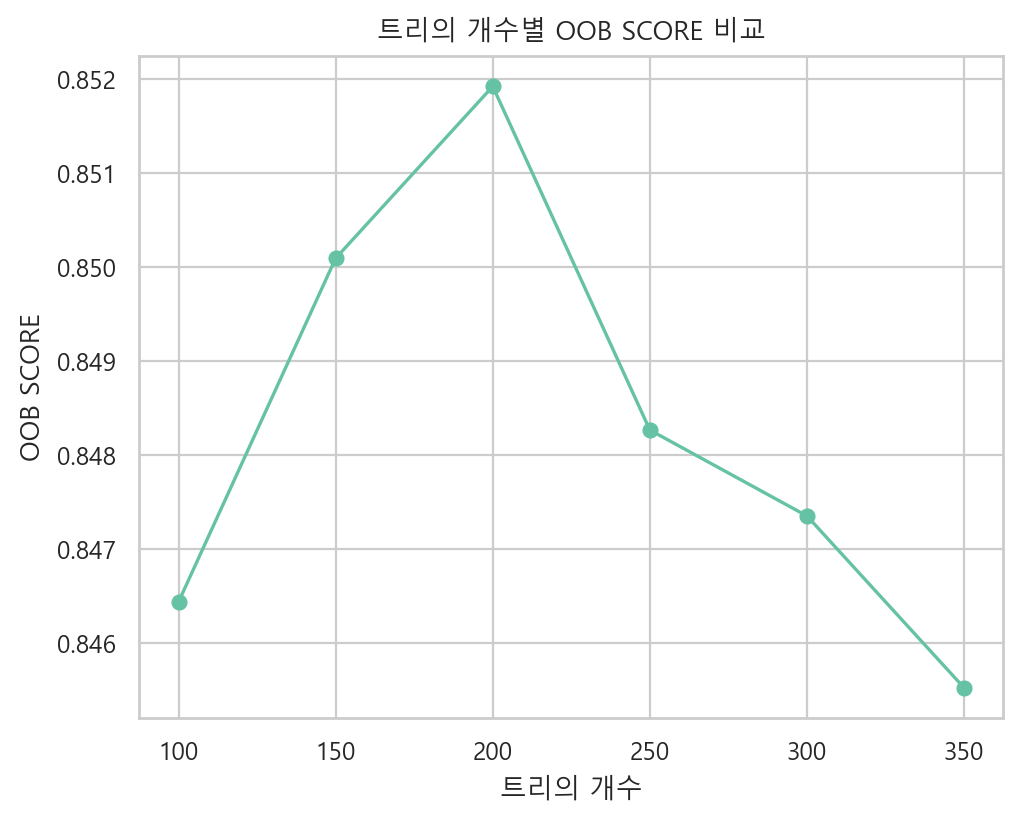

In [14]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(estimators, oob_score, marker = "o")
ax.set(xlabel = "트리의 개수",
       ylabel = "OOB SCORE",
       title = "트리의 개수별 OOB SCORE 비교");

In [15]:
## 각자 params를 지정하여 best_estimator 를 찾으시오. 이때 테스트 데이터에 대한 정확도는?

params = {"max_depth": [2, 3, 4],
          "max_features" : ["sqrt", "log2", None],
          "min_samples_leaf": [i for i in range(5, 10, 2)],
          "min_samples_split": [6,8]}

base_rfc = RandomForestClassifier(n_estimators = 200, 
                               oob_score = True,
                               random_state = 209)

In [16]:
# grid_search(params, base_rfc, -1)

최상의 매개변수:  {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 6}
훈련 데이터의 최고 정확도:  0.8519333081982321
테스트 데이터의 최고 정확도:  0.8273972602739726


In [17]:
rfc_best = RandomForestClassifier(n_estimators = 200, 
                               oob_score = True,
                               random_state = 209,
                               max_depth = 3, 
                               max_features = None, 
                               min_samples_leaf = 7,
                               min_samples_split = 6)

rfc_best.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, max_features=None, min_samples_leaf=7,
                       min_samples_split=6, n_estimators=200, oob_score=True,
                       random_state=209)

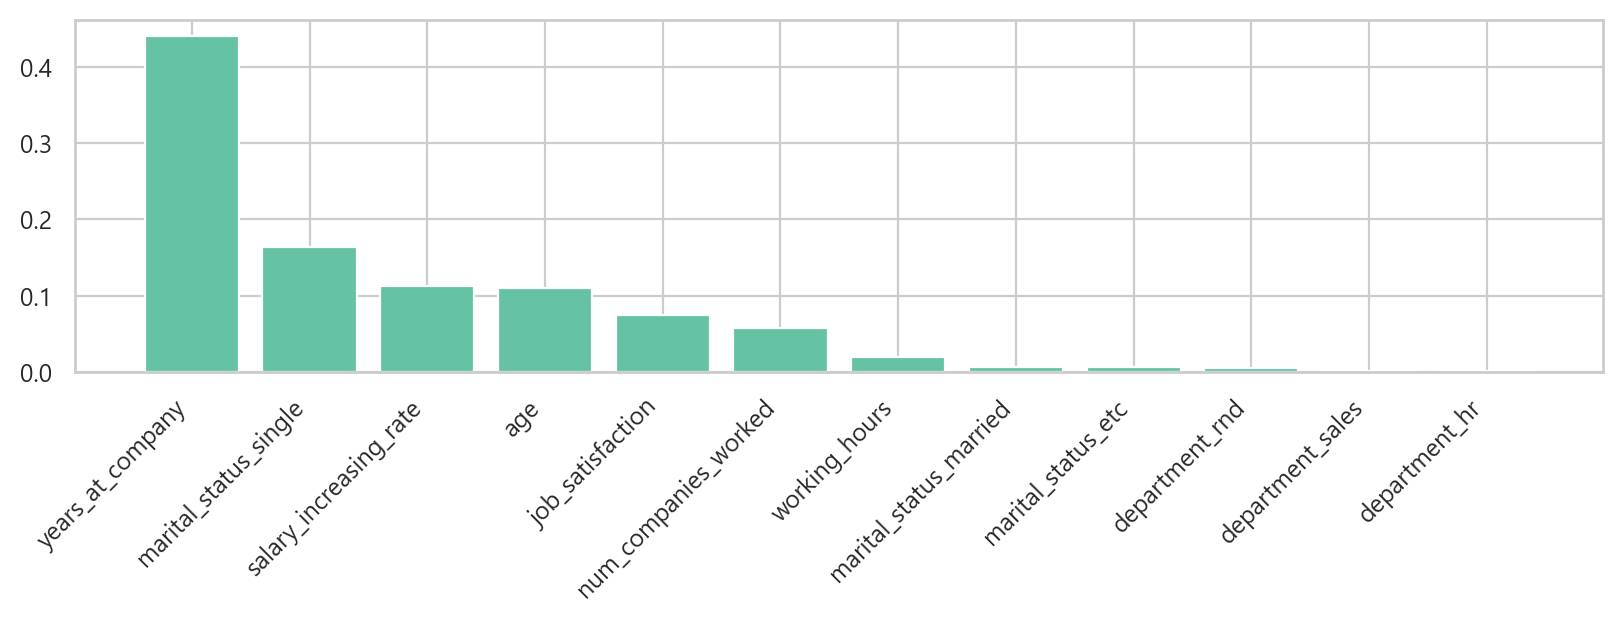

In [19]:
fi_rfc = {name: imp for name, imp in zip(train.columns, rfc_best.feature_importances_)}
fi_rfc_sorted = {k: v for k, v in sorted(fi_rfc.items(), 
                                         key=lambda item: item[1], 
                                         reverse = True)}

fig, ax = plt.subplots(figsize=(8,3))

ax.bar(fi_rfc_sorted.keys(), fi_rfc_sorted.values())
plt.setp(ax.get_xticklabels(), ha="right", rotation=45);

# XGBoost

In [20]:
## HR 데이터에 xgboost 모델을 적용하여 attrition을 분류하는 모델을 만드시오.
xgb = XGBClassifier(booster = "gbtree", 
                    objective = "binary:logistic")
xgb.fit(x_train, y_train)
pred_xgb = xgb.predict(x_test)
print('The accuracy of the xgboost is', metrics.accuracy_score(pred_xgb, y_test))

The accuracy of the xgboost is 0.8054794520547945


In [21]:
## 각자 params를 지정하여 best_estimator 를 찾으시오. 이때 테스트 데이터에 대한 정확도는?

params = {"max_depth": [1, 2, 3],
          "learning_rate" : np.arange(0.01, 0.1, 0.001),
          "n_estimators": np.arange(100, 300, 30)}

base_xgb = XGBClassifier(booster = "gbtree", 
                    objective = "binary:logistic")

In [22]:
# grid_search(params, base_xgb, -1)

최상의 매개변수:  {'learning_rate': 0.030999999999999986, 'max_depth': 3, 'n_estimators': 250}
훈련 데이터의 최고 정확도:  0.860156675463952
테스트 데이터의 최고 정확도:  0.8301369863013699


In [23]:
xgb_best = XGBClassifier(booster = "gbtree", 
                    objective = "binary:logistic",
                    learning_rate = 0.0301, 
                    max_depth = 3, 
                    n_estimators = 250)

xgb_best.fit(x_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0301, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

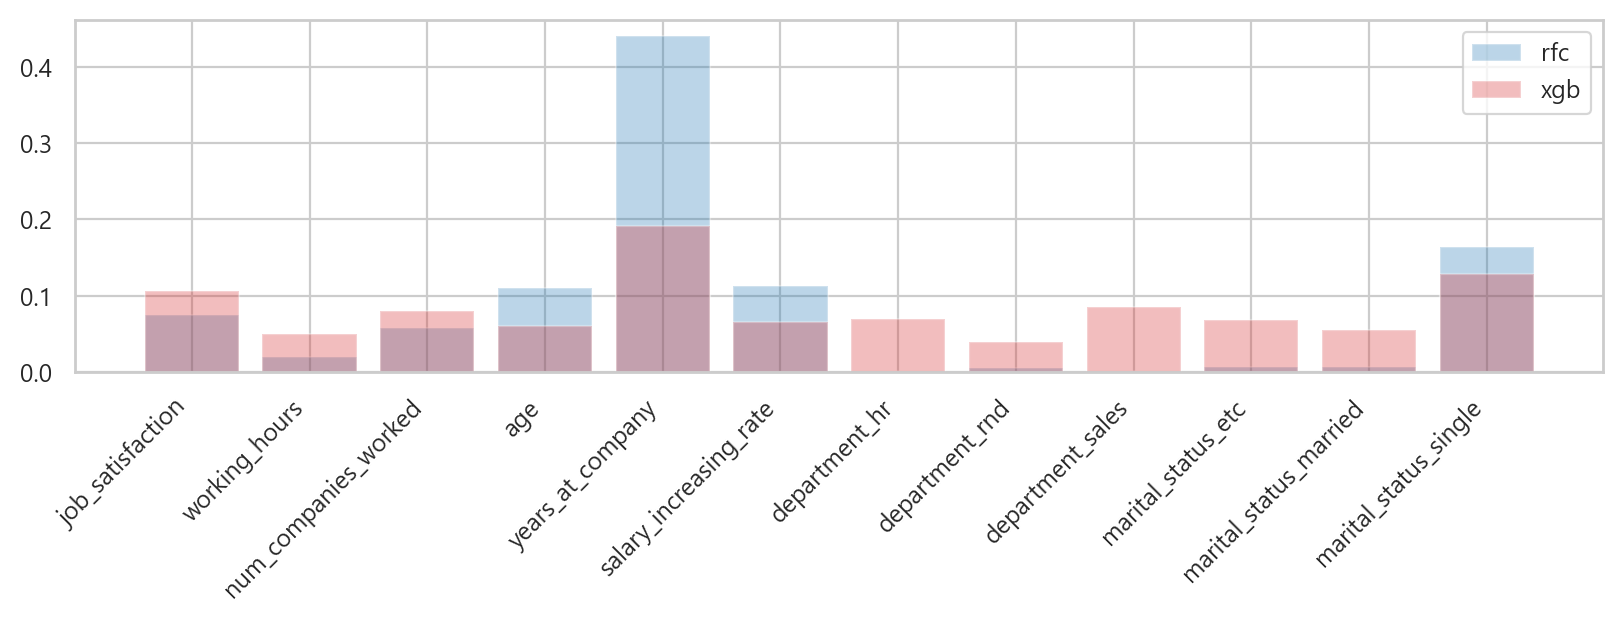

In [24]:
fig, ax = plt.subplots(figsize=(8,3))

ax.bar(train.columns[:-1], 
       rfc_best.feature_importances_, 
       color = "tab:blue", 
       label = "rfc",
       alpha = 0.3)

ax.bar(train.columns[:-1], 
       xgb_best.feature_importances_,
       color = "tab:red", 
       label = "xgb",
       alpha = 0.3)

ax.legend()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45);

In [29]:
#퇴직자 비율
print(test["attrition"].sum()/len(test))
#재직자 비율
print(1-(test["attrition"].sum()/len(test)))

0.16164383561643836
0.8383561643835616


In [31]:
pred = [0]*len(test)

In [33]:
metrics.accuracy_score(pred, y_test)

0.8383561643835616